# Image-Text Mismatch Classifier (BLIP Captioning Approach)

**Goal:** Given a dataset of (text_description, image) pairs, classify whether each pair is a match or mismatch.

**Approach (2-Step):**
1. **Step 1 — Image Captioning:** Use **BLIP** model to generate a description of what the image actually shows
2. **Step 2 — Text Comparison:** Compare the generated caption with the original description using **sentence similarity**

This is more accurate than direct CLIP scoring because:
- You can **see** what the model thinks the image contains
- Text-to-text comparison is more reliable
- Mismatches become visually obvious (e.g., original says "lion" but BLIP says "a robot on white background")

In [1]:
# Install required libraries (run once)
!pip install transformers torch pillow pandas openpyxl requests jinja2 sentence-transformers -q

In [2]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import os
import io
import requests
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 1. Load Models

- **BLIP** (`Salesforce/blip-image-captioning-base`): Generates a text caption from any image
- **Sentence-Transformer** (`all-MiniLM-L6-v2`): Compares two texts and gives a similarity score (0-1)

In [3]:
# Load BLIP for image captioning
print("Loading BLIP image captioning model...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_model.eval()
print("BLIP loaded!")

# Load sentence similarity model
print("\nLoading sentence similarity model...")
sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
print("Sentence-Transformer loaded!")
print("\nBoth models ready.")

Loading BLIP image captioning model...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

BLIP loaded!

Loading sentence similarity model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence-Transformer loaded!

Both models ready.


## 2. Load Your Dataset

In [5]:
FILE_PATH = "Image_Mismatch_data.csv"
TEXT_COL = "Text"
IMAGE_COL = "Image"
SIMILARITY_THRESHOLD = 0.25
SAMPLE_SIZE = 15


# Load the dataset
df_full = pd.read_csv(FILE_PATH)

df_full = df_full.dropna(subset=[TEXT_COL, IMAGE_COL])
df_full = df_full[df_full[IMAGE_COL].str.startswith("http")]
print(f"Full dataset: {len(df_full)} valid rows")

# Sample a subset for testing
if SAMPLE_SIZE:
    df = df_full.head(SAMPLE_SIZE).reset_index(drop=True)
    print(f"Using first {SAMPLE_SIZE} rows for testing")
else:
    df = df_full.reset_index(drop=True)

print(f"\nColumns: {list(df.columns)}")
print(f"Text column: '{TEXT_COL}'")
print(f"Image column: '{IMAGE_COL}' (URLs)")
df[[TEXT_COL, IMAGE_COL]].head()

Full dataset: 14 valid rows
Using first 15 rows for testing

Columns: ['Text', 'Image', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Text column: 'Text'
Image column: 'Image' (URLs)


Text  \
0                         a very typical bus station   
1  a boy looked at a dog while performing with pe...   
2  young confused girl standing in front of a war...   
3  interior design of modern living room with fir...   
4                                   image shows lion   

                                               Image  
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...  
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...  
2  https://media.gettyimages.com/photos/young-con...  
3  https://thumb1.shutterstock.com/display_pic_wi...  
4  https://thumb1.shutterstock.com/display_pic_wi...

## 3. Generate Captions & Compare with Descriptions

For each row:
1. **BLIP** looks at the image and generates a caption (what the image actually shows)
2. **Sentence-Transformer** compares the BLIP caption with the original description
3. **High similarity** (> threshold) = Match, **Low similarity** = Mismatch

You can now **see** what the model thinks each image shows!

In [8]:
def load_image(image_source):
    """Load an image from a URL or local file path."""
    if str(image_source).startswith("http"):
        response = requests.get(image_source, timeout=10)
        response.raise_for_status()
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_source).convert("RGB")
    return image


def generate_caption(image):
    """Use BLIP to generate a caption describing what the image shows."""
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = blip_model.generate(**inputs, max_new_tokens=50)
    caption = blip_processor.decode(output_ids[0], skip_special_tokens=True)
    return caption


def compute_text_similarity(text1, text2):
    """Compute cosine similarity between two texts using sentence embeddings."""
    embeddings = sentence_model.encode([text1, text2], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return similarity


# Process all rows
results = []
loaded_images = {}
print(f"Processing {len(df)} image-text pairs...\n")

for idx, row in df.iterrows():
    original_text = str(row[TEXT_COL])
    img_source = str(row[IMAGE_COL])

    print(f"[{idx+1}/{len(df)}] Original: \"{original_text[:60]}\"")

    try:
        image = load_image(img_source)
    except Exception as e:
        print(f"  [ERROR] Cannot load image: {e}")
        results.append({
            "row_index": idx,
            "original_text": original_text,
            "generated_caption": "N/A",
            "image_source": img_source,
            "similarity_score": None,
            "classification": "Error"
        })
        continue

    # Step 1: Generate caption from image using BLIP
    generated_caption = generate_caption(image)
    print(f"         BLIP says: \"{generated_caption}\"")

    # Step 2: Compare generated caption with original description
    score = compute_text_similarity(original_text, generated_caption)
    label = "Match" if score >= SIMILARITY_THRESHOLD else "Mismatch"
    loaded_images[idx] = image

    results.append({
        "row_index": idx,
        "original_text": original_text,
        "generated_caption": generated_caption,
        "image_source": img_source,
        "similarity_score": round(score, 4),
        "classification": label
    })
    print(f"         Similarity: {score:.4f} -> {label}\n")

results_df = pd.DataFrame(results)
print(f"{'='*60}")
print(f"Done! Processed {len(results_df)} pairs.")
print(f"Successfully loaded: {len(loaded_images)} images")
print(f"Failed: {(results_df['classification'] == 'Error').sum()} images")

Processing 14 image-text pairs...

[1/14] Original: "a very typical bus station"
         BLIP says: "a bunch of buses parked in a street"
         Similarity: 0.5952 -> Match

[2/14] Original: "a boy looked at a dog while performing with person at their "
         BLIP says: "a woman in a black and white striped top and floral skirt"
         Similarity: -0.0595 -> Mismatch

[3/14] Original: "young confused girl standing in front of a wardrobe"
  [ERROR] Cannot load image: 400 Client Error: Bad Request for url: https://media.gettyimages.com/photos/young-confused-girl-standing-in-front-of-a-wardrobe-picture-id511063329?s=612x612
[4/14] Original: "interior design of modern living room with fireplace in a ne"
         BLIP says: "modern fireplace in a new home"
         Similarity: 0.8109 -> Match

[5/14] Original: "image shows lion"
         BLIP says: "a robotic hand reaching up to the sky"
         Similarity: 0.1134 -> Mismatch

[6/14] Original: "types of people in a crowd"
         

## 4. Results Summary

In [9]:
# Display full results table
print("=" * 80)
print("IMAGE-TEXT MISMATCH CLASSIFICATION RESULTS")
print("=" * 80)
print(f"Threshold: {SIMILARITY_THRESHOLD}")
print(f"Total pairs: {len(results_df)}")

valid = results_df[results_df["classification"] != "Error"]
matches = (valid["classification"] == "Match").sum()
mismatches = (valid["classification"] == "Mismatch").sum()
errors = (results_df["classification"] == "Error").sum()

print(f"\n  Matches:    {matches}")
print(f"  Mismatches: {mismatches}")
print(f"  Errors:     {errors}")
print("=" * 80)

# Show comparison table: Original Text vs BLIP Caption vs Score
display_df = results_df[["row_index", "original_text", "generated_caption", "similarity_score", "classification"]].copy()
display_df.columns = ["Row", "Original Description", "BLIP Generated Caption", "Similarity", "Result"]

def highlight_classification(val):
    if val == "Match":
        return "background-color: #c8e6c9; color: #2e7d32; font-weight: bold"
    elif val == "Mismatch":
        return "background-color: #ffcdd2; color: #c62828; font-weight: bold"
    elif val == "Error":
        return "background-color: #fff9c4; color: #f57f17; font-weight: bold"
    return ""

styled = (display_df
    .style
    .map(highlight_classification, subset=["Result"])
    .set_properties(**{"text-align": "left"})
    .set_caption("Original Description vs BLIP Caption (Green=Match, Red=Mismatch)")
    .format({"Similarity": "{:.4f}"}, na_rep="N/A")
)
display(styled)

IMAGE-TEXT MISMATCH CLASSIFICATION RESULTS
Threshold: 0.25
Total pairs: 14

  Matches:    5
  Mismatches: 5
  Errors:     4


## 5. Visual Inspection — See Each Image with Its Score

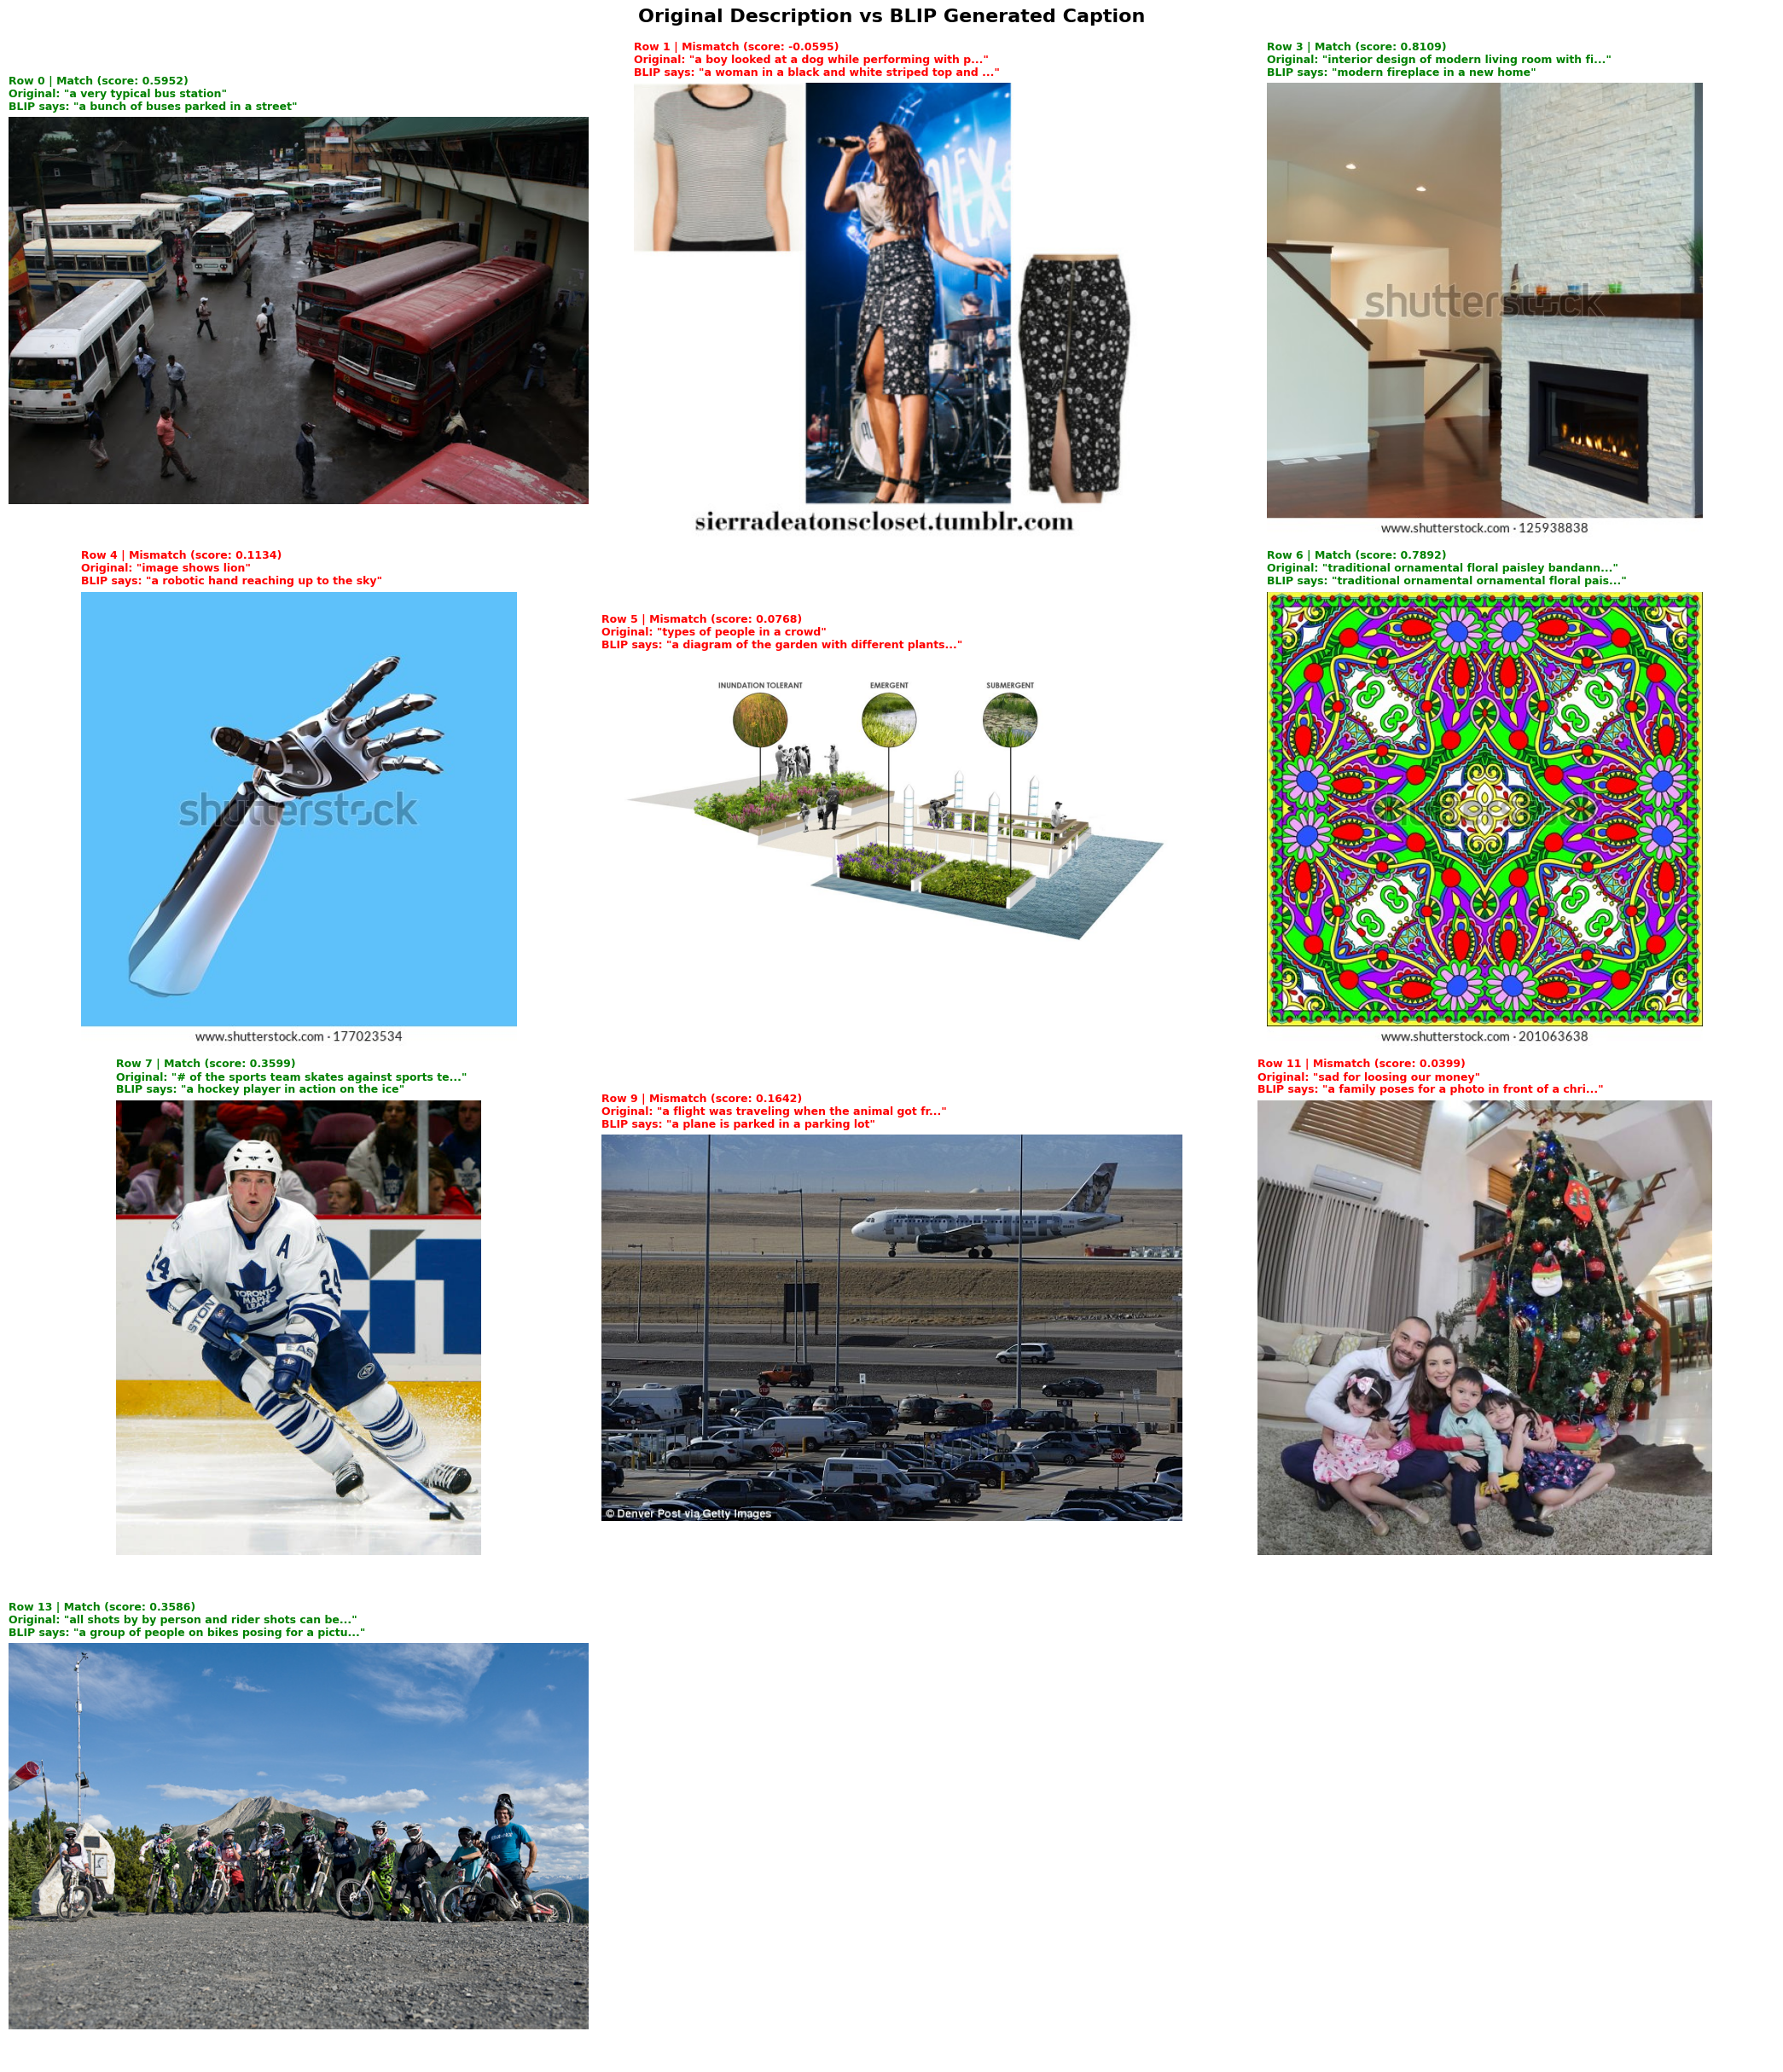

In [10]:
# Visualize each image with Original Text vs BLIP Caption
valid_results = results_df[results_df["classification"] != "Error"]
n = len(valid_results)
cols = 3
rows = max(1, (n + cols - 1) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 6 * rows))
axes_flat = np.array(axes).flatten() if n > 1 else [axes]

for i, (_, row) in enumerate(valid_results.iterrows()):
    ax = axes_flat[i]
    row_idx = row["row_index"]

    if row_idx in loaded_images:
        ax.imshow(loaded_images[row_idx])
    else:
        ax.text(0.5, 0.5, "Image\nNot Found", ha="center", va="center",
                fontsize=14, transform=ax.transAxes)

    score = row["similarity_score"]
    label = row["classification"]
    color = "green" if label == "Match" else "red"

    orig = row["original_text"][:45] + ("..." if len(str(row["original_text"])) > 45 else "")
    blip = row["generated_caption"][:45] + ("..." if len(str(row["generated_caption"])) > 45 else "")

    ax.set_title(
        f"Row {row_idx} | {label} (score: {score})\n"
        f"Original: \"{orig}\"\n"
        f"BLIP says: \"{blip}\"",
        fontsize=9, color=color, fontweight="bold", loc="left"
    )
    ax.axis("off")

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.tight_layout()
plt.suptitle("Original Description vs BLIP Generated Caption", fontsize=16, y=1.01, fontweight="bold")
plt.show()

## 6. Score Distribution — Histogram

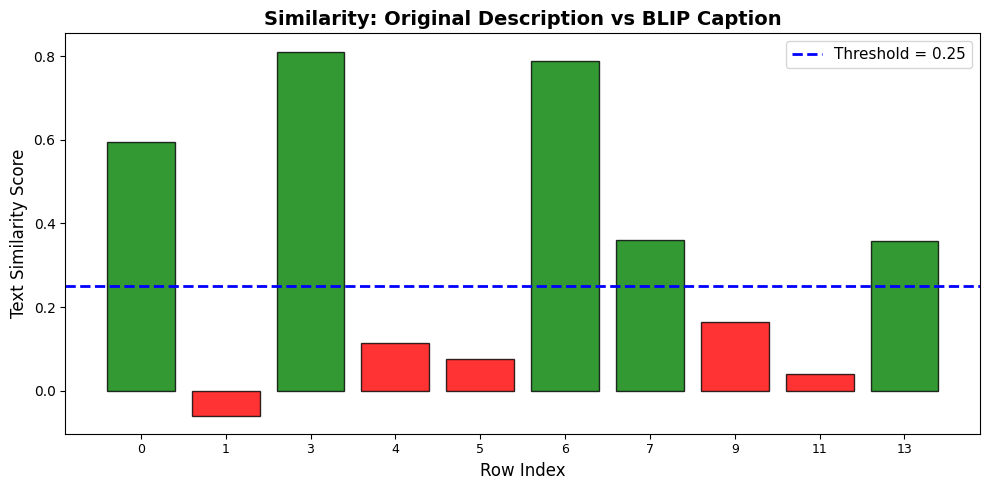

In [11]:
# Score distribution histogram
valid_scores = results_df.dropna(subset=["similarity_score"])

fig, ax = plt.subplots(figsize=(10, 5))

colors = ["green" if c == "Match" else "red" for c in valid_scores["classification"]]
ax.bar(range(len(valid_scores)), valid_scores["similarity_score"], color=colors, edgecolor="black", alpha=0.8)
ax.axhline(y=SIMILARITY_THRESHOLD, color="blue", linestyle="--", linewidth=2, label=f"Threshold = {SIMILARITY_THRESHOLD}")

ax.set_xlabel("Row Index", fontsize=12)
ax.set_ylabel("Text Similarity Score", fontsize=12)
ax.set_title("Similarity: Original Description vs BLIP Caption", fontsize=14, fontweight="bold")
ax.set_xticks(range(len(valid_scores)))
ax.set_xticklabels(valid_scores["row_index"], fontsize=9)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 7. Export Results

In [12]:
# Save results to CSV
output_path = "image_text_mismatch_results.csv"
results_df.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

# Show mismatches with detailed comparison
mismatched = results_df[results_df["classification"] == "Mismatch"]
if len(mismatched) > 0:
    print(f"\n{'='*70}")
    print(f"FLAGGED MISMATCHES ({len(mismatched)} found):")
    print(f"{'='*70}")
    for _, row in mismatched.iterrows():
        print(f"\n  Row {row['row_index']}:")
        print(f"    Original:      \"{row['original_text'][:80]}\"")
        print(f"    BLIP Caption:  \"{row['generated_caption'][:80]}\"")
        print(f"    Similarity:    {row['similarity_score']}")
        print(f"    Image:         {row['image_source'][:80]}")
else:
    print("\nNo mismatches found — all image-text pairs appear to match!")

Results saved to: image_text_mismatch_results.csv

FLAGGED MISMATCHES (5 found):

  Row 1:
    Original:      "a boy looked at a dog while performing with person at their former university"
    BLIP Caption:  "a woman in a black and white striped top and floral skirt"
    Similarity:    -0.0595
    Image:         http://78.media.tumblr.com/3b133294bdc7c7784b781b45eb9af7be/tumblr_nbirmjpEme1tk

  Row 4:
    Original:      "image shows lion"
    BLIP Caption:  "a robotic hand reaching up to the sky"
    Similarity:    0.1134
    Image:         https://thumb1.shutterstock.com/display_pic_with_logo/324673/177023534/stock-pho

  Row 5:
    Original:      "types of people in a crowd"
    BLIP Caption:  "a diagram of the garden with different plants and plants"
    Similarity:    0.0768
    Image:         https://prismpub.com/wp-content/uploads/2016/11/Chicago-Riverwalk_graphic_13.jpg

  Row 9:
    Original:      "a flight was traveling when the animal got free on tuesday night"
    BLIP Capt